# Educational Process Mining

https://archive-beta.ics.uci.edu/dataset/346/educational+process+mining+epm+a+learning+analytics+data+set

Educational Process Mining (EPM): A Learning Analytics Data Set. (2015). UCI Machine Learning Repository.

This notebook reads in the data set created by the DATA notebook and includes part 1 of the exploratory data analysis, which resulted in more data cleaning and more new variables. It outputs 3 cleaned input datasets.

New variables include `active_ms`, the difference between `total_ms` and `idle_ms` and transformation variables for all numeric inputs to correct skewness. Skewness was only resolved for `mm` (mouse movement). The variables `idel_tm` and `mw` (mouse wheel) improved but are still not gaussian. Transformation methods included natural log, windsorizing, and square root.

Evaluation of `idle_time` revealed that 158 records had a negative `idle_time`, and these values were replaced with NaN.

Evaluation of active_ms revealed that `idle_ms` was greater than `total_ms` for 53,202 records (~23%), and these negative `active_ms` values were replaced with NaN.

Evaluation of `total_ms` revealed one record that had a negative value, which corresponds with an `end_dt` that was earlier than the `start_dt`. These will be treated as unknown and were replaced with NaT. This evaluation also revealed that 59,767 records (\~26%) had 0 `total_ms`, which corresponds with `end_dt` and `start_dt` that are equal. Of these records with equal `start_dt` and `end_dt`, 3,392 records (\~5.7%) have a value of 0 in every mouse/keystroke field: (`mw` + `mwc` + `mcl` + `mcr` + `mm` + `ks`) == 0.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

### Load the data from github repository

In [2]:
inputs_path = 'https://raw.githubusercontent.com/lisaover/CMPINF2120_project/main/inputs_df.csv'
interim_path = 'https://raw.githubusercontent.com/lisaover/CMPINF2120_project/main/interim_df.csv'
final_path = 'https://raw.githubusercontent.com/lisaover/CMPINF2120_project/main/final_df.csv'
pts_path = 'https://raw.githubusercontent.com/lisaover/CMPINF2120_project/main/final_points_lookup.csv'

In [3]:
inputs_init = pd.read_csv(inputs_path)

In [4]:
interim_init = pd.read_csv(interim_path)

In [5]:
final_init = pd.read_csv(final_path)

In [6]:
pts_final_lookup = pd.read_csv(pts_path)

In [7]:
inputs_init.columns

Index(['sess', 'sid', 'exer', 'actv', 'actv_grp', 'actv_exer', 'start_dt',
       'end_dt', 'total_ms', 'idle_ms', 'mw', 'mwc', 'mcl', 'mcr', 'mm', 'ks'],
      dtype='object')

In [8]:
interim_init.columns

Index(['sid', 'interim_scr2', 'interim_scr3', 'interim_scr4', 'interim_scr5',
       'interim_scr6'],
      dtype='object')

In [9]:
final_init.columns

Index(['sid', 'Es_1q1', 'Es_1q2', 'Es_2q1', 'Es_2q2', 'Es_3q1', 'Es_3q2',
       'Es_3q3', 'Es_3q4', 'Es_3q5', 'Es_4q1', 'Es_4q2', 'Es_5q1', 'Es_5q2',
       'Es_5q3', 'Es_6q1', 'Es_6q2', 'final_score'],
      dtype='object')

In [10]:
pts_final_lookup.columns

Index(['question', 'question_points'], dtype='object')

## Inputs

There are 16 columns:

* Two ID columns as type integer - sess and sid
* Six object columns, two should be dates - exer, actv, actv_grp, actv_exer, start_dt, and end_dt
* Eight integer columns - total_ms, idle_ms, mouse_wheel, mouse_wheel_click, mouse_click_left, mouse_click_right, mouse_movement, and keystoke

There are missing data only in the column `actv_exer` because it is a derived column from splitting the original `actv` column into two columns, one to hold the activity group and the other the exercise associated with the activity - not all activity was associated with a specific exercise.

There are 158 records where `idle_ms` is negative. About 26% of the data has start and end times that are equal. About 23% of the data have an `idle_ms` that is greater than the derived `total_ms`, and this was calculated after assigning NaN to `total_ms` where it equaled zero because of equal start and end times.

In [11]:
inputs_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227129 entries, 0 to 227128
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sess       227129 non-null  int64  
 1   sid        227129 non-null  int64  
 2   exer       227129 non-null  object 
 3   actv       227129 non-null  object 
 4   actv_grp   227129 non-null  object 
 5   actv_exer  111979 non-null  object 
 6   start_dt   227129 non-null  object 
 7   end_dt     227129 non-null  object 
 8   total_ms   227129 non-null  float64
 9   idle_ms    227129 non-null  int64  
 10  mw         227129 non-null  int64  
 11  mwc        227129 non-null  int64  
 12  mcl        227129 non-null  int64  
 13  mcr        227129 non-null  int64  
 14  mm         227129 non-null  int64  
 15  ks         227129 non-null  int64  
dtypes: float64(1), int64(9), object(6)
memory usage: 27.7+ MB


In [12]:
inputs_init.isna().sum()

sess              0
sid               0
exer              0
actv              0
actv_grp          0
actv_exer    115150
start_dt          0
end_dt            0
total_ms          0
idle_ms           0
mw                0
mwc               0
mcl               0
mcr               0
mm                0
ks                0
dtype: int64

### Evaluate ID and date columns

In [13]:
inputs_init.sess.nunique()

6

In [14]:
inputs_init.sess.unique()

array([1, 2, 3, 4, 5, 6])

In [15]:
inputs_init.sid.nunique()

113

In [16]:
inputs_init.sid.unique()

array([  1,   2,   4,   5,   7,   9,  10,  11,  12,  14,  15,  17,  19,
        20,  21,  22,  28,  30,  32,  34,  36,  37,  38,  39,  42,  43,
        44,  46,  47,  49,  51,  52,  53,  54,  55,  56,  59,  62,  63,
        66,  67,  68,  70,  71,  73,  74,  76,  78,  79,  80,  81,  82,
        85,  86,  87,  88,  90,  91,  92,  93,  94,  96,  97,  98, 100,
       101, 102, 104, 105, 108, 109, 110, 111, 112, 113, 114,   3,   6,
         8,  16,  18,  24,  27,  29,  41,  48,  50,  61,  72,  83,  84,
        95,  99, 103,  23,  25,  31,  35,  45,  69,  75,  89, 106,  13,
        26,  33,  40,  57,  58,  60,  64,  65,  77])

##### Convert student_id and session to object type

In [17]:
inputs_init['sid'] = inputs_init['sid'].astype('object')
inputs_init['sess'] = inputs_init['sess'].astype('object')

##### Convert start_time and end_time to datetime type and add variable for the total time

The variable `idle_time` is the duration of idle time between the start and end times in milliseconds.

In [18]:
inputs_init['start_dt'] = pd.to_datetime(inputs_init['start_dt'])
inputs_init['end_dt'] = pd.to_datetime(inputs_init['end_dt'])

##### Evaluate `idle_ms` and `total_ms` values

`idle_ms` has 158 negative values, all of which are large in magnitude with a min of -2.06 x 10^14. The average values for the mouse and keyboard actions are mostly higher for this group than those for the set of records with positive or zero idle times. 

`total_ms` has one record with negative values because the start date is greater than the end date. About 26% of records have a `total_ms` of 0 because the start and end times are equal. Of these records with equal start and end times, there are mouse and keyboard actions recorded for about 94% of them.

In [19]:
inputs_init['idle_ms'].describe()

count    2.271290e+05
mean    -1.873839e+09
std      4.528877e+11
min     -2.059092e+14
25%      0.000000e+00
50%      7.900000e+01
75%      5.719000e+03
max      7.244736e+09
Name: idle_ms, dtype: float64

In [20]:
inputs_init.loc[inputs_init['idle_ms'] < 0].shape[0]

158

In [21]:
inputs_init.loc[inputs_init['idle_ms'] < 0].describe()

,total_ms,idle_ms,mw,mwc,mcl,mcr,mm,ks
count,158.000000,1.580000e+02,158.000000,158.0,158.000000,158.000000,158.000000,158.000000
mean,29177.215190,-2.695335e+12,7.987342,0.0,6.955696,0.607595,560.537975,16.316456
std,66599.144903,1.701228e+13,25.769183,0.0,11.049019,2.648964,687.320243,78.981501
min,1000.000000,-2.059092e+14,0.000000,0.0,0.000000,0.000000,13.000000,0.000000
25%,2000.000000,-3.639984e+11,0.000000,0.0,2.000000,0.000000,168.000000,0.000000
50%,7000.000000,-3.221225e+10,0.000000,0.0,4.000000,0.000000,312.000000,0.000000
75%,27500.000000,-4.294967e+09,0.750000,0.0,6.000000,0.000000,627.500000,0.000000
max,624000.000000,-4.294833e+09,172.000000,0.0,82.000000,22.000000,4153.000000,850.000000


In [22]:
inputs_init.loc[inputs_init['idle_ms'] >= 0].describe()

,total_ms,idle_ms,mw,mwc,mcl,mcr,mm,ks
count,2.269710e+05,2.269710e+05,226971.000000,226971.000000,226971.000000,226971.000000,226971.000000,226971.000000
mean,1.584867e+04,1.144022e+06,2.703433,0.005454,7.076023,0.336642,414.526257,6.274912
std,6.111513e+04,2.977009e+07,27.103456,0.224617,21.564804,3.023388,1276.142958,50.923113
min,-6.120000e+05,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000,0.000000,62.000000,0.000000
50%,2.000000e+03,8.000000e+01,0.000000,0.000000,2.000000,0.000000,137.000000,0.000000
75%,9.000000e+03,5.740500e+03,0.000000,0.000000,5.000000,0.000000,335.000000,0.000000
max,3.861000e+06,7.244736e+09,2904.000000,60.000000,1096.000000,168.000000,85949.000000,4754.000000


In [23]:
inputs_init['total_ms'].describe()

count    2.271290e+05
mean     1.585794e+04
std      6.111997e+04
min     -6.120000e+05
25%      0.000000e+00
50%      2.000000e+03
75%      9.000000e+03
max      3.861000e+06
Name: total_ms, dtype: float64

In [24]:
inputs_init.loc[inputs_init['total_ms'] < 0].shape[0]

1

In [25]:
inputs_init.loc[inputs_init['total_ms'] < 0]

,sess,sid,exer,actv,actv_grp,actv_exer,start_dt,end_dt,total_ms,idle_ms,mw,mwc,mcl,mcr,mm,ks
137606,4,89,Es_4_5,Diagram,Diagram,NaN,2014-11-13 13:50:40,2014-11-13 13:40:28,-612000.0,30681,0,0,42,0,636,0


In [26]:
inputs_init.loc[inputs_init['start_dt'] > inputs_init['end_dt']]

,sess,sid,exer,actv,actv_grp,actv_exer,start_dt,end_dt,total_ms,idle_ms,mw,mwc,mcl,mcr,mm,ks
137606,4,89,Es_4_5,Diagram,Diagram,NaN,2014-11-13 13:50:40,2014-11-13 13:40:28,-612000.0,30681,0,0,42,0,636,0


In [27]:
inputs_init.loc[inputs_init['total_ms'] == 0].describe()

,total_ms,idle_ms,mw,mwc,mcl,mcr,mm,ks
count,59767.0,59767.0,59767.000000,59767.000000,59767.000000,59767.000000,59767.000000,59767.000000
mean,0.0,0.0,0.024662,0.001071,1.753074,0.039487,58.992588,0.086268
std,0.0,0.0,0.600667,0.048387,1.004523,0.277212,60.357439,0.825030
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,1.000000,0.000000,25.000000,0.000000
50%,0.0,0.0,0.000000,0.000000,2.000000,0.000000,51.000000,0.000000
75%,0.0,0.0,0.000000,0.000000,2.000000,0.000000,79.000000,0.000000
max,0.0,0.0,69.000000,5.000000,12.000000,6.000000,780.000000,38.000000


In [28]:
inputs_init.loc[inputs_init['total_ms'] >= 0].describe()

,total_ms,idle_ms,mw,mwc,mcl,mcr,mm,ks
count,2.271280e+05,2.271280e+05,227128.000000,227128.000000,227128.000000,227128.000000,227128.000000,227128.000000
mean,1.586071e+04,-1.873848e+09,2.707121,0.005451,7.075785,0.336832,414.626854,6.281925
std,6.110590e+04,4.528886e+11,27.102914,0.224539,21.559182,3.023153,1275.835525,50.948531
min,0.000000e+00,-2.059092e+14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000,0.000000,62.000000,0.000000
50%,2.000000e+03,7.900000e+01,0.000000,0.000000,2.000000,0.000000,137.000000,0.000000
75%,9.000000e+03,5.719000e+03,0.000000,0.000000,5.000000,0.000000,335.000000,0.000000
max,3.861000e+06,7.244736e+09,2904.000000,60.000000,1096.000000,168.000000,85949.000000,4754.000000


#### <span style="color:red">Should anything be done to start and end times when they are equal?</span>

In [29]:
chk = inputs_init.copy()

In [30]:
chk['zero_time'] = np.where(chk['start_dt'] == chk['end_dt'], 1, 0)

In [31]:
chk['zero_time'].sum()

59767

In [32]:
chk['zero_time'].mean()

0.26314121050152117

In [33]:
chk.loc[(chk['zero_time'] == 1) & ((chk.mw + chk.mwc + chk.mcl + chk.mcr + chk.mm + chk.ks) == 0)]

,sess,sid,exer,actv,actv_grp,actv_exer,start_dt,end_dt,total_ms,idle_ms,mw,mwc,mcl,mcr,mm,ks,zero_time
169,1,1,Es_1_2,Study_Es_1_2,Study,Es_1_2,2014-02-10 12:14:34,2014-02-10 12:14:34,0.0,0,0,0,0,0,0,0,1
593,1,2,Es_1_1,Other,Other,NaN,2014-02-10 11:38:24,2014-02-10 11:38:24,0.0,0,0,0,0,0,0,0,1
594,1,2,Es_1_1,Blank,Blank,NaN,2014-02-10 11:38:25,2014-02-10 11:38:25,0.0,0,0,0,0,0,0,0,1
597,1,2,Es_1_1,Blank,Blank,NaN,2014-02-10 11:38:43,2014-02-10 11:38:43,0.0,0,0,0,0,0,0,0,1
607,1,2,Es_1_1,Deeds_Es_1_1,Deeds,Es_1_1,2014-02-10 11:50:25,2014-02-10 11:50:25,0.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221884,6,91,Es_6_3,FSM_Related,FSM_Related,NaN,2014-11-12 13:41:14,2014-11-12 13:41:14,0.0,0,0,0,0,0,0,0,1
221932,6,91,Es_6_4,Deeds,Deeds,NaN,2014-11-12 13:55:51,2014-11-12 13:55:51,0.0,0,0,0,0,0,0,0,1
223522,6,94,Es_6_3,Blank,Blank,NaN,2014-11-12 13:38:41,2014-11-12 13:38:41,0.0,0,0,0,0,0,0,0,1
226070,6,99,Es_6_1,Other,Other,NaN,2014-11-12 11:35:01,2014-11-12 11:35:01,0.0,0,0,0,0,0,0,0,1


In [34]:
chk['zero_activity'] = np.where((chk.mw + chk.mwc + chk.mcl + chk.mcr + chk.mm + chk.ks) == 0, 1, 0)

In [35]:
chk['zero_activity'].sum()

9650

In [36]:
chk['zero_activity'].mean()

0.0424868686957632

In [37]:
chk.loc[(chk['zero_time'] == 1)].zero_activity.sum()

3392

In [38]:
chk.loc[(chk['zero_time'] == 1)].zero_activity.mean()

0.05675372697307879

##### Change values to NaN or NaT for  `idle_ms`, `total_ms`, `start_dt`, and `end_dt` for values that are considered missing:

* Negative `idle_ms` values
<!--* Zero `total_ms` values-->
* Negative `total_ms` values and the corresponding `start_dt` and `end_dt`

In [39]:
inputs_init['idle_ms'] = inputs_init['idle_ms'].astype('float')
inputs_init['total_ms'] = inputs_init['total_ms'].astype('float')

In [40]:
inputs_init['idle_ms'] = [x if x >= 0 else np.nan for x in inputs_init['idle_ms']]

In [41]:
inputs_init['total_ms'] = [x if x >= 0 else np.nan for x in inputs_init['total_ms']]

In [42]:
inputs_init['idle_ms'].describe()

count    2.269710e+05
mean     1.144022e+06
std      2.977009e+07
min      0.000000e+00
25%      0.000000e+00
50%      8.000000e+01
75%      5.740500e+03
max      7.244736e+09
Name: idle_ms, dtype: float64

In [43]:
inputs_init['total_ms'].describe()


count    2.271280e+05
mean     1.586071e+04
std      6.110590e+04
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+03
75%      9.000000e+03
max      3.861000e+06
Name: total_ms, dtype: float64

In [44]:
inputs_init['total_ms'].loc[inputs_init['total_ms'].isna()].shape[0]

1

In [45]:
inputs_init['end_dt2'] = [pd.Timestamp('nat') if i > j else j for (i, j) in zip(inputs_init['start_dt'],inputs_init['end_dt'])]

In [46]:
inputs_init['start_dt2'] = [pd.Timestamp('nat') if i == pd.Timestamp('nat') else i for (i, j) in zip(inputs_init['start_dt'],inputs_init['end_dt'])]

In [47]:
inputs_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227129 entries, 0 to 227128
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   sess       227129 non-null  object        
 1   sid        227129 non-null  object        
 2   exer       227129 non-null  object        
 3   actv       227129 non-null  object        
 4   actv_grp   227129 non-null  object        
 5   actv_exer  111979 non-null  object        
 6   start_dt   227129 non-null  datetime64[ns]
 7   end_dt     227129 non-null  datetime64[ns]
 8   total_ms   227128 non-null  float64       
 9   idle_ms    226971 non-null  float64       
 10  mw         227129 non-null  int64         
 11  mwc        227129 non-null  int64         
 12  mcl        227129 non-null  int64         
 13  mcr        227129 non-null  int64         
 14  mm         227129 non-null  int64         
 15  ks         227129 non-null  int64         
 16  end_dt2    227128 no

##### Calculate `active_ms` as difference between `total_ms` and `idle_ms`

In [48]:
inputs_init['active_ms'] = inputs_init['total_ms'] - inputs_init['idle_ms']

In [49]:
inputs_init['active_ms'].describe()

count    2.269700e+05
mean    -1.128175e+06
std      2.973134e+07
min     -7.240875e+09
25%      0.000000e+00
50%      1.265000e+02
75%      2.000000e+03
max      3.738236e+06
Name: active_ms, dtype: float64

#### <span style="color:red">Should anything be done when the `idle_ms` is greater than the derived `total_ms`?</span>

In [50]:
chk['neg_active'] = np.where(chk['idle_ms'] > chk['total_ms'], 1, 0)

In [51]:
chk['neg_active'].sum()

53202

In [52]:
chk['neg_active'].mean()

0.23423693143543978

In [53]:
inputs_init.loc[inputs_init['active_ms'] < 0].describe()

,total_ms,idle_ms,mw,mwc,mcl,mcr,mm,ks,active_ms
count,5.320100e+04,5.320100e+04,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,5.320100e+04
mean,5.796536e+04,4.877783e+06,8.263510,0.012669,18.430311,1.080656,1108.941975,22.798087,-4.819818e+06
std,1.147357e+05,6.134233e+07,53.465434,0.417148,41.435602,6.058820,2441.302877,97.327373,6.126529e+07
min,1.000000e+03,1.001000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.240875e+09
25%,1.200000e+04,2.384900e+04,0.000000,0.000000,2.000000,0.000000,155.000000,0.000000,-6.285500e+05
50%,2.600000e+04,1.062540e+05,0.000000,0.000000,5.000000,0.000000,435.000000,0.000000,-7.816000e+04
75%,5.800000e+04,6.877070e+05,0.000000,0.000000,16.000000,0.000000,1106.000000,4.000000,-9.661000e+03
max,3.861000e+06,7.244736e+09,2904.000000,60.000000,1096.000000,168.000000,85949.000000,3102.000000,-1.000000e+00


##### Change negative `active_ms` to NaN

In [54]:
inputs_init['active_ms'] = [x if x >= 0 else np.nan for x in inputs_init['active_ms']]

In [55]:
inputs_init['active_ms'].describe()

count    1.737690e+05
mean     2.055835e+03
std      1.088817e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+03
75%      2.859000e+03
max      3.738236e+06
Name: active_ms, dtype: float64

### Evaluate categorical variables

In [56]:
inputs_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227129 entries, 0 to 227128
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   sess       227129 non-null  object        
 1   sid        227129 non-null  object        
 2   exer       227129 non-null  object        
 3   actv       227129 non-null  object        
 4   actv_grp   227129 non-null  object        
 5   actv_exer  111979 non-null  object        
 6   start_dt   227129 non-null  datetime64[ns]
 7   end_dt     227129 non-null  datetime64[ns]
 8   total_ms   227128 non-null  float64       
 9   idle_ms    226971 non-null  float64       
 10  mw         227129 non-null  int64         
 11  mwc        227129 non-null  int64         
 12  mcl        227129 non-null  int64         
 13  mcr        227129 non-null  int64         
 14  mm         227129 non-null  int64         
 15  ks         227129 non-null  int64         
 16  end_dt2    227128 no

In [57]:
inputs_init.exer.nunique()

30

In [58]:
inputs_init.exer.unique()

array(['Es', 'Es_1_1', 'Es_1_2', 'Es_1_4', 'Es_1_3', 'Es_2_1', 'Es_2_2',
       'Es_2_3', 'Es_2_4', 'Es_2_5', 'Es_2_6', 'Es_3_1', 'Es_3_2',
       'Es_3_3', 'Es_3_4', 'Es_4_1', 'Es_4_2', 'Es_4_3', 'Es_4_4',
       'Es_4_5', 'Es_5_2', 'Es_5_1', 'Es_5_3', 'Es_5_4', 'Es_6_1',
       'Es_6_2', 'Es_6_3', 'Es_6_4', 'Es_6_6', 'Es_6_5'], dtype=object)

In [59]:
inputs_init.actv_grp.unique()

array(['Other', 'Aulaweb', 'Blank', 'Deeds', 'Study', 'Properties',
       'Diagram', 'TextEditor', 'Study_Materials', 'Fsm_Related', 'FSM',
       'FSM_Related'], dtype=object)

In [60]:
inputs_init.actv_grp.nunique()

12

In [61]:
inputs_init.actv_grp.unique()

array(['Other', 'Aulaweb', 'Blank', 'Deeds', 'Study', 'Properties',
       'Diagram', 'TextEditor', 'Study_Materials', 'Fsm_Related', 'FSM',
       'FSM_Related'], dtype=object)

In [62]:
inputs_init['actv_grp'] = inputs_init['actv_grp'].str.replace("Fsm", "FSM", 1)

In [63]:
inputs_init.actv_grp.unique()

array(['Other', 'Aulaweb', 'Blank', 'Deeds', 'Study', 'Properties',
       'Diagram', 'TextEditor', 'Study_Materials', 'FSM_Related', 'FSM'],
      dtype=object)

In [64]:
inputs_init.actv_grp.value_counts()

TextEditor         41900
Deeds              38000
Other              33009
Blank              23929
Study              21540
Diagram            20546
Properties         19419
FSM                17000
Aulaweb             8113
FSM_Related         3275
Study_Materials      398
Name: actv_grp, dtype: int64

In [65]:
inputs_init.actv_exer.nunique()

29

In [66]:
inputs_init.actv_exer.unique()

array([nan, 'Es_1_1', 'Es_1_2', 'Es_1_4', 'Es_3_1', 'Es_1_3', 'Es_4_1',
       'Es_4_2', 'Es_4_3', 'Es_4_4', 'Es_2_1', 'Es_2_2', 'Es_2_3',
       'Es_2_4', 'Es_2_5', 'Es_2_6', 'Es_3_2', 'Es_3_3', 'Es_3_4',
       'Es_4_5', 'Es_5_2', 'Es_5_1', 'Es_5_3', 'Es_5_4', 'Es_6_1',
       'Es_6_2', 'Es_6_3', 'Es_6_4', 'Es_6_6', 'Es_6_5'], dtype=object)

In [67]:
inputs_init.actv_exer.value_counts()

Es_6_3    10471
Es_6_2     8356
Es_6_1     7105
Es_4_5     6812
Es_5_4     6671
Es_3_2     6094
Es_2_2     5665
Es_5_1     4790
Es_1_2     4752
Es_5_3     4484
Es_2_4     4454
Es_3_1     4340
Es_1_1     4325
Es_2_1     4318
Es_1_3     3491
Es_2_3     3209
Es_4_1     2711
Es_5_2     2684
Es_3_4     2595
Es_3_3     2548
Es_1_4     2517
Es_2_5     2379
Es_4_2     1892
Es_4_3     1729
Es_4_4     1574
Es_2_6     1311
Es_6_4      629
Es_6_5       37
Es_6_6       36
Name: actv_exer, dtype: int64

### Evaluate numeric variables

In [68]:
inputs_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227129 entries, 0 to 227128
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   sess       227129 non-null  object        
 1   sid        227129 non-null  object        
 2   exer       227129 non-null  object        
 3   actv       227129 non-null  object        
 4   actv_grp   227129 non-null  object        
 5   actv_exer  111979 non-null  object        
 6   start_dt   227129 non-null  datetime64[ns]
 7   end_dt     227129 non-null  datetime64[ns]
 8   total_ms   227128 non-null  float64       
 9   idle_ms    226971 non-null  float64       
 10  mw         227129 non-null  int64         
 11  mwc        227129 non-null  int64         
 12  mcl        227129 non-null  int64         
 13  mcr        227129 non-null  int64         
 14  mm         227129 non-null  int64         
 15  ks         227129 non-null  int64         
 16  end_dt2    227128 no

### Outlier Resolution

##### Create functions to get summary of numeric columns

Trivial groupby column to aggregate on all rows per the following:

https://github.com/pandas-dev/pandas/issues/41768

#### <span style="color:red">The two outlier summaries are not consistent with how they report outliers for `idle_ms`, `total_ms`, and `active_ms`.</span>

In [69]:
def my_q25(values):
    return np.percentile( values, q=25 )

In [70]:
def my_q75(values):
    return np.percentile( values, q=75 )

In [71]:
def my_iqr(values):
    return my_q75(values) - my_q25(values)

In [72]:
def upper_outlier_bound(values): 
    return my_q75(values) + 1.5 * my_iqr(values)

In [73]:
def lower_outlier_bound(values): 
    return my_q25(values) - 1.5 * my_iqr(values)

In [74]:
def var_name(values):
    return values.name

In [75]:
def outliers_exist(values):
    if (values.min() < lower_outlier_bound(values)) or (values.max() > upper_outlier_bound(values)):
        return 'Yes'
    else: 
        return 'No'

In [76]:
def percent_outliers(values):
    df = pd.DataFrame(values)
    df['outlier'] = np.where((df[values.name] < lower_outlier_bound(values)) | (df[values.name] > upper_outlier_bound(values)), 1, 0)
    return round(df['outlier'].mean()*100, 1)

In [77]:
def get_summary(df_in):
    
    df_out = pd.DataFrame(columns=['var_name', 'nunique', 'mean', 'median', 
                                   'min', 'lower_outlier_bound', 'max', 'upper_outlier_bound',
                                   'outliers_exist', 'percent_outliers'])
    
    # add trivial groupby column
    df_in['all'] = 'grp_all'
    
    for var in df_in.select_dtypes('number').columns.tolist():
        df_out = pd.concat([df_out, df_in.loc[df_in[var].notnull()].groupby(['all'])[var].\
                           aggregate( [var_name, 'nunique', 'mean', 'median', 
                                       'min', lower_outlier_bound, 'max', upper_outlier_bound, 
                                       outliers_exist, percent_outliers] ).\
                           reset_index().copy()])
        
    return df_out.drop('all', axis=1)

In [78]:
get_summary(inputs_init.copy())

,var_name,nunique,mean,median,min,lower_outlier_bound,max,upper_outlier_bound,outliers_exist,percent_outliers
0,total_ms,890,1.586071e+04,2000.0,0.0,-13500.00,3.861000e+06,22500.00,Yes,13.8
0,idle_ms,54071,1.144022e+06,80.0,0.0,-8610.75,7.244736e+09,14351.25,Yes,20.2
0,mw,460,2.707109e+00,0.0,0.0,0.00,2.904000e+03,0.00,Yes,9.2
0,mwc,17,5.450647e-03,0.0,0.0,0.00,6.000000e+01,0.00,Yes,0.2
0,mcl,394,7.075939e+00,2.0,0.0,-2.50,1.096000e+03,9.50,Yes,12.9
0,mcr,75,3.368306e-01,0.0,0.0,0.00,1.680000e+02,0.00,Yes,5.6
0,mm,6221,4.146278e+02,137.0,0.0,-347.50,8.594900e+04,744.50,Yes,11.5
0,ks,808,6.281897e+00,0.0,0.0,0.00,4.754000e+03,0.00,Yes,14.7
0,active_ms,12018,2.055835e+03,1000.0,0.0,-4288.50,3.738236e+06,7147.50,Yes,5.2


In [79]:
inputs_xdf = inputs_init.copy()

In [80]:
inputs_xdf.isna().sum()

sess              0
sid               0
exer              0
actv              0
actv_grp          0
actv_exer    115150
start_dt          0
end_dt            0
total_ms          1
idle_ms         158
mw                0
mwc               0
mcl               0
mcr               0
mm                0
ks                0
end_dt2           1
start_dt2         0
active_ms     53360
dtype: int64

In [81]:
def upper_extreme_val(values):
    return np.percentile( values, q=97.5 )

In [82]:
def lower_extreme_val(values):
    return np.percentile( values, q=2.5 )

In [83]:
outchk = inputs_init.copy()

In [84]:
vars_to_chk = ['total_ms', 'idle_ms', 'mw', 
               'mwc', 'mcl',
               'mcr', 'mm', 
               'ks', 'active_ms']

In [85]:
def low_outlier_chk(varstr):
    global outchk
    new_var = varstr + '_low'
    outchk[new_var] = np.where(outchk[varstr] < lower_outlier_bound(outchk[varstr]), 1, 0)
    return outchk[new_var].mean()  

In [86]:
def high_outlier_chk(varstr):
    global outchk
    new_var = varstr + '_high'
    outchk[new_var] = np.where(outchk[varstr] > upper_outlier_bound(outchk[varstr]), 1, 0) 
    return outchk[new_var].mean()

In [87]:
outliers = pd.DataFrame({'variable': [v for v in vars_to_chk],
                        'low outliers (%)': [low_outlier_chk(v) for v in vars_to_chk],
                        'high outliers (%)': [high_outlier_chk(v) for v in vars_to_chk]})

In [88]:
outliers

,variable,low outliers (%),high outliers (%)
0,total_ms,0.0,0.000000
1,idle_ms,0.0,0.000000
2,mw,0.0,0.092291
3,mwc,0.0,0.001625
4,mcl,0.0,0.129446
5,mcr,0.0,0.056307
6,mm,0.0,0.114798
7,ks,0.0,0.146947
8,active_ms,0.0,0.000000


In [89]:
inputs_xdf.columns

Index(['sess', 'sid', 'exer', 'actv', 'actv_grp', 'actv_exer', 'start_dt',
       'end_dt', 'total_ms', 'idle_ms', 'mw', 'mwc', 'mcl', 'mcr', 'mm', 'ks',
       'end_dt2', 'start_dt2', 'active_ms'],
      dtype='object')

##### Natural Log

In [90]:
inputs_xdf['total_ms_ln'] = np.log(inputs_xdf[['total_ms']].replace(0, np.nan))

In [91]:
inputs_xdf['idle_ms_ln'] = np.log(inputs_xdf[['idle_ms']].replace(0, np.nan))

In [92]:
inputs_xdf['mw_ln'] = np.log(inputs_xdf[['mw']].replace(0, np.nan))

In [93]:
inputs_xdf['mwc_ln'] = np.log(inputs_xdf[['mwc']].replace(0, np.nan))

In [94]:
inputs_xdf['mcl_ln'] = np.log(inputs_xdf[['mcl']].replace(0, np.nan))

In [95]:
inputs_xdf['mcr_ln'] = np.log(inputs_xdf[['mcr']].replace(0, np.nan))

In [96]:
inputs_xdf['mm_ln'] = np.log(inputs_xdf[['mm']].replace(0, np.nan))

In [97]:
inputs_xdf['ks_ln'] = np.log(inputs_xdf[['ks']].replace(0, np.nan))

##### Windsorize

In [98]:
xtr_lwr = lower_extreme_val(inputs_xdf['total_ms'].copy().dropna(how='any'))
xtr_upr = upper_extreme_val(inputs_xdf['total_ms'].copy().dropna(how='any'))

In [99]:
inputs_xdf['total_ms'].describe()

count    2.271280e+05
mean     1.586071e+04
std      6.110590e+04
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+03
75%      9.000000e+03
max      3.861000e+06
Name: total_ms, dtype: float64

In [100]:
inputs_xdf['total_ms_wdz'] = [x if x >= xtr_lwr else xtr_lwr for x in inputs_xdf['total_ms']]

In [101]:
inputs_xdf['total_ms_wdz'] = [x if x <= xtr_upr else xtr_upr for x in inputs_xdf['total_ms']]

In [102]:
inputs_xdf['total_ms_wdz'].describe()

count    227129.000000
mean      11820.022983
std       24910.445151
min           0.000000
25%           0.000000
50%        2000.000000
75%        9000.000000
max      122000.000000
Name: total_ms_wdz, dtype: float64

In [103]:
xtr_lwr = lower_extreme_val(inputs_xdf['idle_ms'].copy().dropna(how='any'))
xtr_upr = upper_extreme_val(inputs_xdf['idle_ms'].copy().dropna(how='any'))

In [104]:
inputs_xdf['idle_ms_wdz'] = [x if x >= xtr_lwr else xtr_lwr for x in inputs_xdf['idle_ms']]

In [105]:
inputs_xdf['idle_ms_wdz'] = [x if x <= xtr_upr else xtr_upr for x in inputs_xdf['idle_ms']]

In [106]:
xtr_lwr = lower_extreme_val(inputs_xdf['mw'])
xtr_upr = upper_extreme_val(inputs_xdf['mw'])

In [107]:
inputs_xdf['mw_wdz'] = [x if x >= xtr_lwr else xtr_lwr for x in inputs_xdf['mw']]

In [108]:
inputs_xdf['mw_wdz'] = [x if x <= xtr_upr else xtr_upr for x in inputs_xdf['mw']]

In [109]:
xtr_lwr = lower_extreme_val(inputs_xdf['mwc'])
xtr_upr = upper_extreme_val(inputs_xdf['mwc'])

In [110]:
inputs_xdf['mwc_wdz'] = [x if x >= xtr_lwr else xtr_lwr for x in inputs_xdf['mwc']]

In [111]:
inputs_xdf['mwc_wdz'] = [x if x <= xtr_upr else xtr_upr for x in inputs_xdf['mwc']]

In [112]:
xtr_lwr = lower_extreme_val(inputs_xdf['mcl'])
xtr_upr = upper_extreme_val(inputs_xdf['mcl'])

In [113]:
inputs_xdf['mcl_wdz'] = [x if x >= xtr_lwr else xtr_lwr for x in inputs_xdf['mcl']]

In [114]:
inputs_xdf['mcl_wdz'] = [x if x <= xtr_upr else xtr_upr for x in inputs_xdf['mcl']]

In [115]:
xtr_lwr = lower_extreme_val(inputs_xdf['mcr'])
xtr_upr = upper_extreme_val(inputs_xdf['mcr'])

In [116]:
inputs_xdf['mcr_wdz'] = [x if x >= xtr_lwr else xtr_lwr for x in inputs_xdf['mcr']]

In [117]:
inputs_xdf['mcr_wdz'] = [x if x <= xtr_upr else xtr_upr for x in inputs_xdf['mcr']]

In [118]:
xtr_lwr = lower_extreme_val(inputs_xdf['mm'])
xtr_upr = upper_extreme_val(inputs_xdf['mm'])

In [119]:
inputs_xdf['mm_wdz'] = [x if x >= xtr_lwr else xtr_lwr for x in inputs_xdf['mm']]

In [120]:
inputs_xdf['mm_wdz'] = [x if x <= xtr_upr else xtr_upr for x in inputs_xdf['mm']]

In [121]:
xtr_lwr = lower_extreme_val(inputs_xdf['ks'])
xtr_upr = upper_extreme_val(inputs_xdf['ks'])

In [122]:
inputs_xdf['ks_wdz'] = [x if x >= xtr_lwr else xtr_lwr for x in inputs_xdf['ks']]

In [123]:
inputs_xdf['ks_wdz'] = [x if x <= xtr_upr else xtr_upr for x in inputs_xdf['ks']]

##### Square Root

In [124]:
inputs_xdf['total_ms_sqrt'] = np.sqrt(inputs_xdf[['total_ms']])

In [125]:
inputs_xdf['idle_ms_sqrt'] = np.sqrt(inputs_xdf[['idle_ms']])

In [126]:
inputs_xdf['mw_sqrt'] = np.sqrt(inputs_xdf[['mw']])

In [127]:
inputs_xdf['mwc_sqrt'] = np.sqrt(inputs_xdf[['mwc']])

In [128]:
inputs_xdf['mcl_sqrt'] = np.sqrt(inputs_xdf[['mcl']])

In [129]:
inputs_xdf['mcr_sqrt'] = np.sqrt(inputs_xdf[['mcr']])

In [130]:
inputs_xdf['mm_sqrt'] = np.sqrt(inputs_xdf[['mm']])

In [131]:
inputs_xdf['ks_sqrt'] = np.sqrt(inputs_xdf[['ks']])

##### `total_ms`

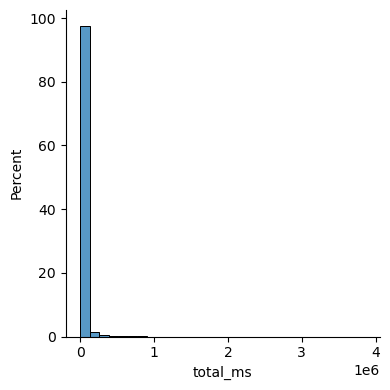

In [132]:
sns.displot(
    inputs_xdf, x='total_ms', stat='percent', kind='hist', bins=30, height=4)

plt.show()

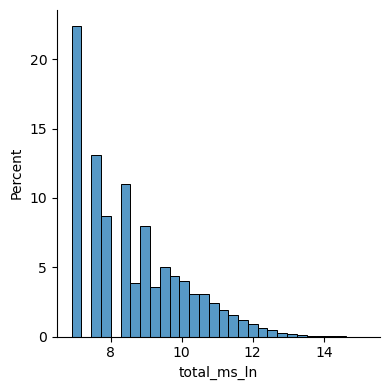

In [133]:
sns.displot(
    inputs_xdf, x='total_ms_ln', stat='percent', kind='hist', bins=30, height=4)

plt.show()

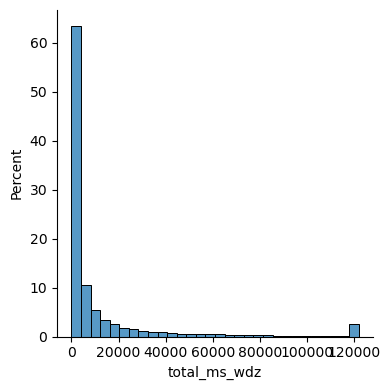

In [134]:
sns.displot(
    inputs_xdf, x='total_ms_wdz', stat='percent', kind='hist', bins=30, height=4)

plt.show()

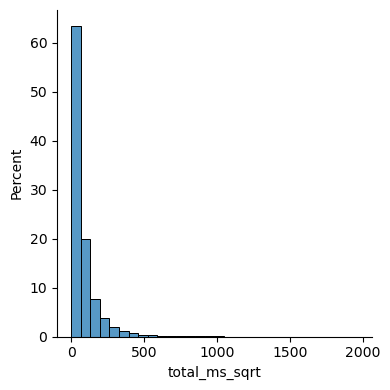

In [135]:
sns.displot(
    inputs_xdf, x='total_ms_sqrt', stat='percent', kind='hist', bins=30, height=4)

plt.show()

##### `idle_ms`

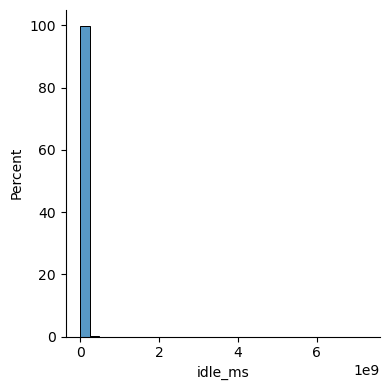

In [136]:
sns.displot(
    inputs_xdf, x='idle_ms', stat='percent', kind='hist', bins=30, height=4)

plt.show()

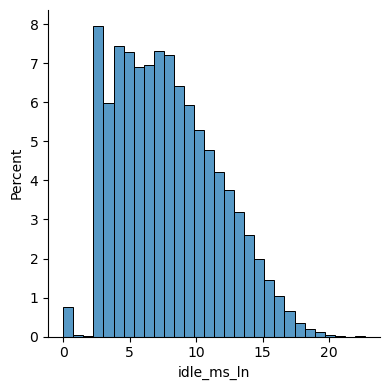

In [137]:
sns.displot(
    inputs_xdf, x='idle_ms_ln', stat='percent', kind='hist', bins=30, height=4)

plt.show()

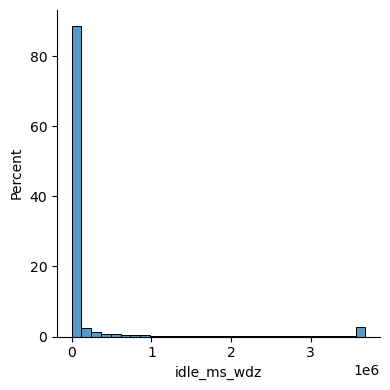

In [138]:
sns.displot(
    inputs_xdf, x='idle_ms_wdz', stat='percent', kind='hist', bins=30, height=4)

plt.show()

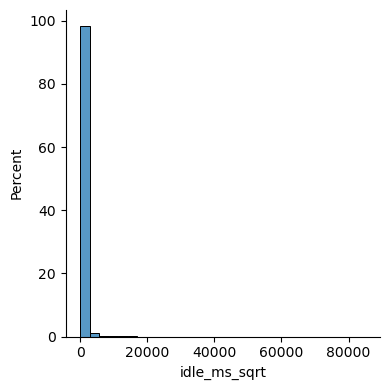

In [139]:
sns.displot(
    inputs_xdf, x='idle_ms_sqrt', stat='percent', kind='hist', bins=30, height=4)

plt.show()

##### `mouse_wheel`

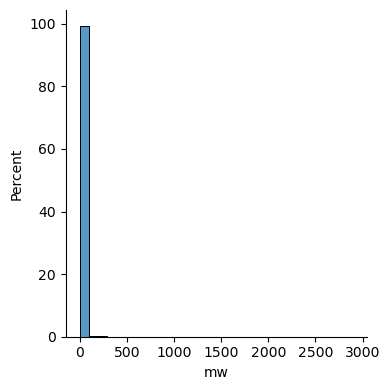

In [140]:
sns.displot(
    inputs_xdf, x='mw', stat='percent', kind='hist', bins=30, height=4)

plt.show()

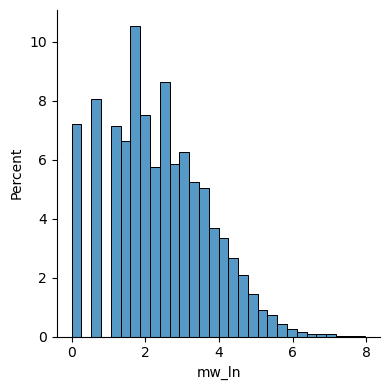

In [141]:
sns.displot(
    inputs_xdf, x='mw_ln', stat='percent', kind='hist', bins=30, height=4)

plt.show()

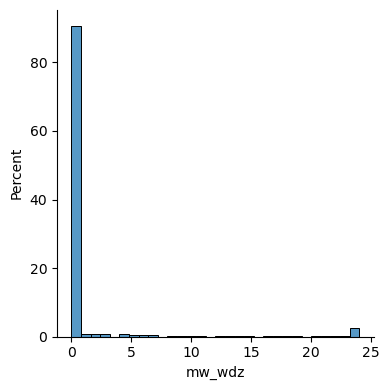

In [142]:
sns.displot(
    inputs_xdf, x='mw_wdz', stat='percent', kind='hist', bins=30, height=4)

plt.show()

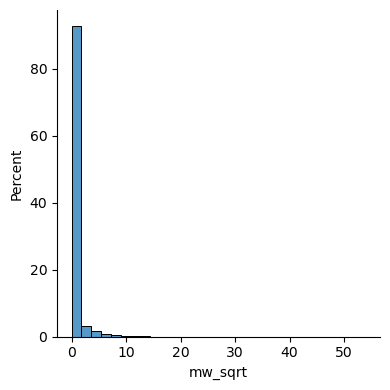

In [143]:
sns.displot(
    inputs_xdf, x='mw_sqrt', stat='percent', kind='hist', bins=30, height=4)

plt.show()

##### `mouse_wheel_click`

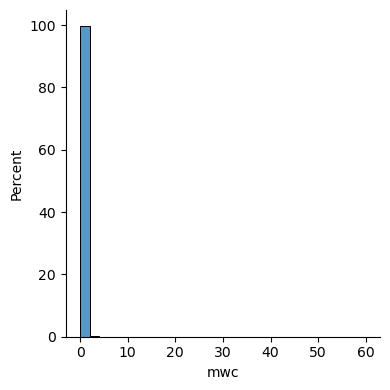

In [144]:
sns.displot(
    inputs_xdf, x='mwc', stat='percent', kind='hist', bins=30, height=4)

plt.show()

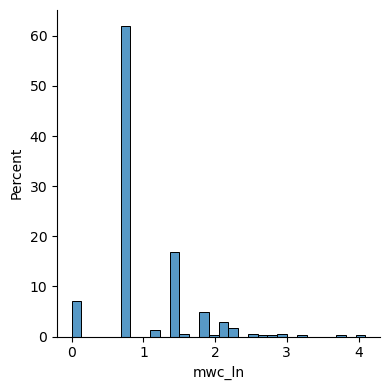

In [145]:
sns.displot(
    inputs_xdf, x='mwc_ln', stat='percent', kind='hist', bins=30, height=4)

plt.show()

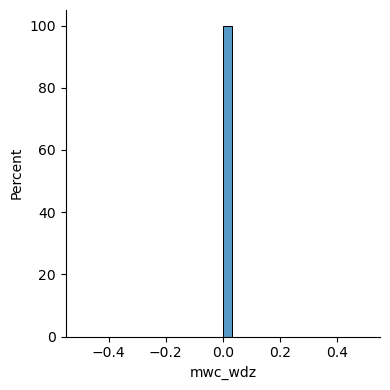

In [146]:
sns.displot(
    inputs_xdf, x='mwc_wdz', stat='percent', kind='hist', bins=30, height=4)

plt.show()

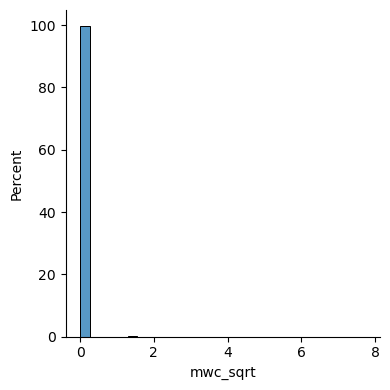

In [147]:
sns.displot(
    inputs_xdf, x='mwc_sqrt', stat='percent', kind='hist', bins=30, height=4)

plt.show()

##### `mouse_click_left`

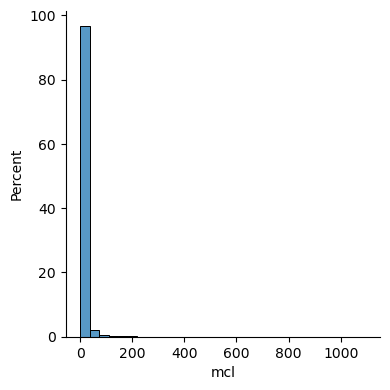

In [148]:
sns.displot(
    inputs_xdf, x='mcl', stat='percent', kind='hist', bins=30, height=4)

plt.show()

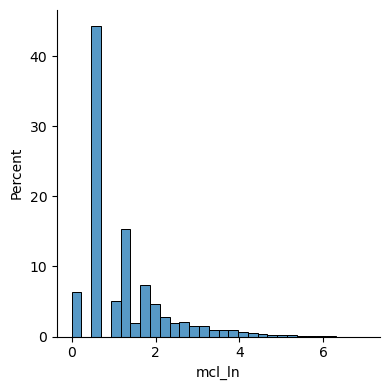

In [149]:
sns.displot(
    inputs_xdf, x='mcl_ln', stat='percent', kind='hist', bins=30, height=4)

plt.show()

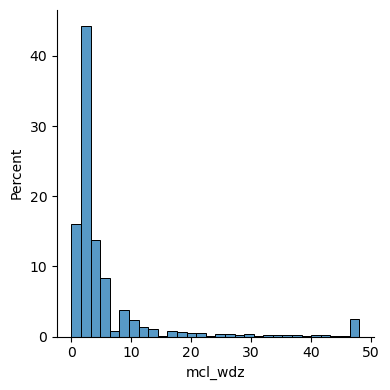

In [150]:
sns.displot(
    inputs_xdf, x='mcl_wdz', stat='percent', kind='hist', bins=30, height=4)

plt.show()

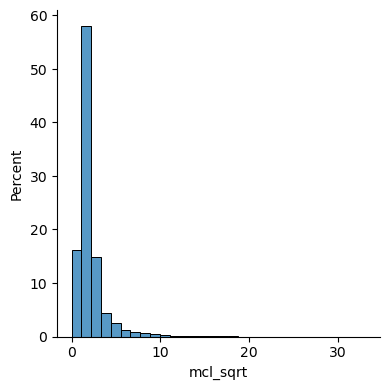

In [151]:
sns.displot(
    inputs_xdf, x='mcl_sqrt', stat='percent', kind='hist', bins=30, height=4)

plt.show()

##### `mouse_click_right`

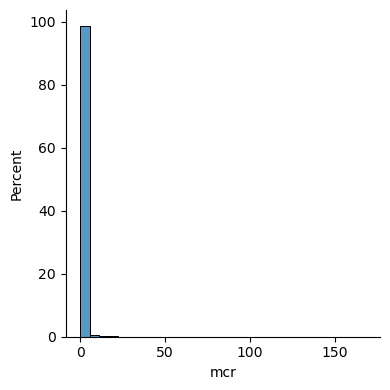

In [152]:
sns.displot(
    inputs_xdf, x='mcr', stat='percent', kind='hist', bins=30, height=4)

plt.show()

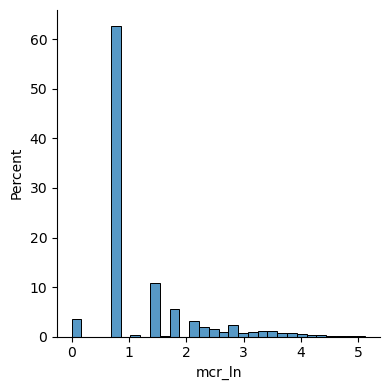

In [153]:
sns.displot(
    inputs_xdf, x='mcr_ln', stat='percent', kind='hist', bins=30, height=4)

plt.show()

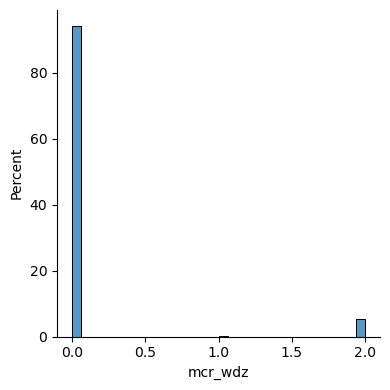

In [154]:
sns.displot(
    inputs_xdf, x='mcr_wdz', stat='percent', kind='hist', bins=30, height=4)

plt.show()

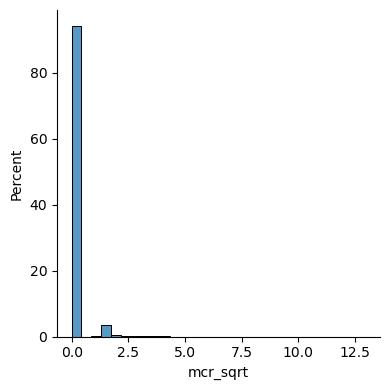

In [155]:
sns.displot(
    inputs_xdf, x='mcr_sqrt', stat='percent', kind='hist', bins=30, height=4)

plt.show()

##### `mouse_movement`

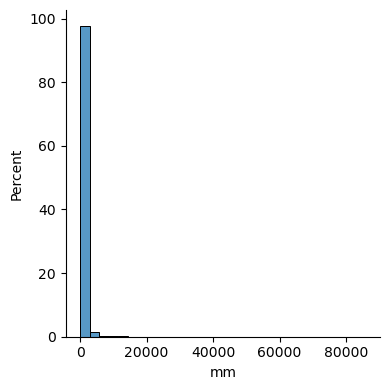

In [156]:
sns.displot(
    inputs_xdf, x='mm', stat='percent', kind='hist', bins=30, height=4)

plt.show()

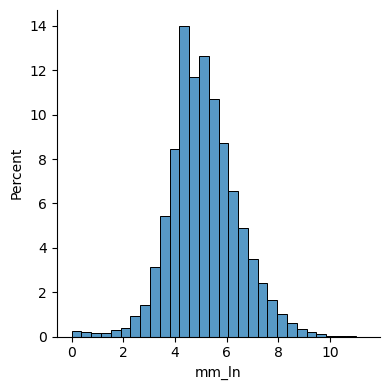

In [157]:
sns.displot(
    inputs_xdf, x='mm_ln', stat='percent', kind='hist', bins=30, height=4)

plt.show()

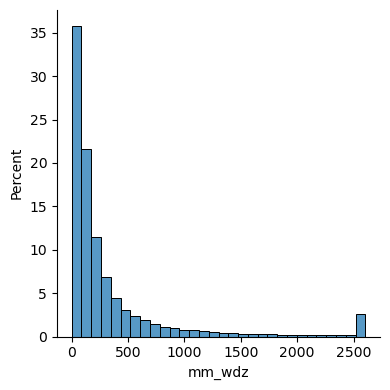

In [158]:
sns.displot(
    inputs_xdf, x='mm_wdz', stat='percent', kind='hist', bins=30, height=4)

plt.show()

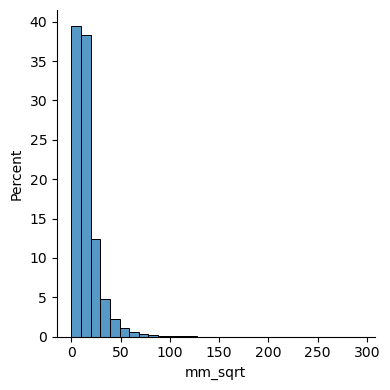

In [159]:
sns.displot(
    inputs_xdf, x='mm_sqrt', stat='percent', kind='hist', bins=30, height=4)

plt.show()

##### `keystroke`

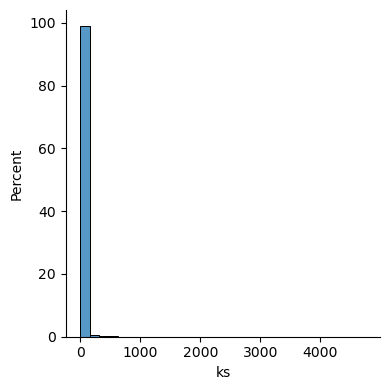

In [160]:
sns.displot(
    inputs_xdf, x='ks', stat='percent', kind='hist', bins=30, height=4)

plt.show()

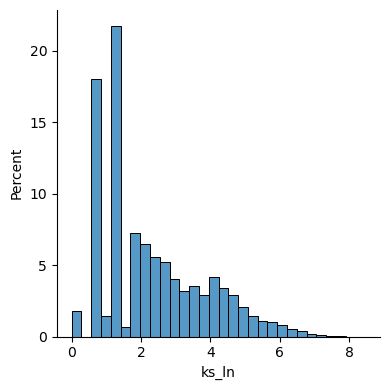

In [161]:
sns.displot(
    inputs_xdf, x='ks_ln', stat='percent', kind='hist', bins=30, height=4)

plt.show()

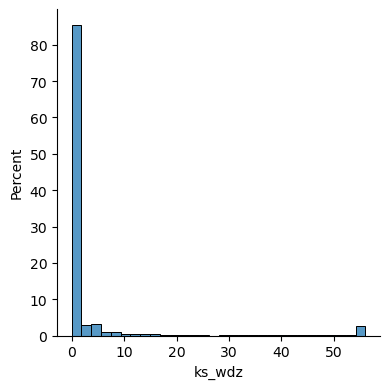

In [162]:
sns.displot(
    inputs_xdf, x='ks_wdz', stat='percent', kind='hist', bins=30, height=4)

plt.show()

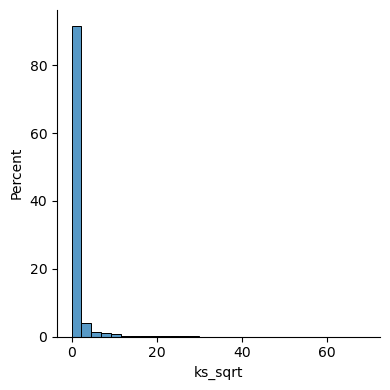

In [163]:
sns.displot(
    inputs_xdf, x='ks_sqrt', stat='percent', kind='hist', bins=30, height=4)

plt.show()

In [164]:
inputs_xdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227129 entries, 0 to 227128
Data columns (total 43 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   sess           227129 non-null  object        
 1   sid            227129 non-null  object        
 2   exer           227129 non-null  object        
 3   actv           227129 non-null  object        
 4   actv_grp       227129 non-null  object        
 5   actv_exer      111979 non-null  object        
 6   start_dt       227129 non-null  datetime64[ns]
 7   end_dt         227129 non-null  datetime64[ns]
 8   total_ms       227128 non-null  float64       
 9   idle_ms        226971 non-null  float64       
 10  mw             227129 non-null  int64         
 11  mwc            227129 non-null  int64         
 12  mcl            227129 non-null  int64         
 13  mcr            227129 non-null  int64         
 14  mm             227129 non-null  int64         
 15  

#### Select original variables and sqrt/windsorized transformations  (nlog produces too many NaN values because of the 0s)

In [165]:
inputs_xdf.columns

Index(['sess', 'sid', 'exer', 'actv', 'actv_grp', 'actv_exer', 'start_dt',
       'end_dt', 'total_ms', 'idle_ms', 'mw', 'mwc', 'mcl', 'mcr', 'mm', 'ks',
       'end_dt2', 'start_dt2', 'active_ms', 'total_ms_ln', 'idle_ms_ln',
       'mw_ln', 'mwc_ln', 'mcl_ln', 'mcr_ln', 'mm_ln', 'ks_ln', 'total_ms_wdz',
       'idle_ms_wdz', 'mw_wdz', 'mwc_wdz', 'mcl_wdz', 'mcr_wdz', 'mm_wdz',
       'ks_wdz', 'total_ms_sqrt', 'idle_ms_sqrt', 'mw_sqrt', 'mwc_sqrt',
       'mcl_sqrt', 'mcr_sqrt', 'mm_sqrt', 'ks_sqrt'],
      dtype='object')

In [166]:
inputs_out = inputs_xdf[['sess', 'sid', 'start_dt2', 'end_dt2', 'exer', 'actv', 'actv_grp', 
                         'total_ms', 'idle_ms', 'mw', 'mwc', 'mcl', 'mcr', 'mm', 'ks', 
                         'total_ms_wdz', 'idle_ms_wdz', 'mw_wdz', 'mwc_wdz', 'mcl_wdz', 
                         'mcr_wdz', 'mm_wdz', 'ks_wdz', 'total_ms_sqrt', 'idle_ms_sqrt', 
                         'mw_sqrt', 'mwc_sqrt', 'mcl_sqrt', 'mcr_sqrt', 'mm_sqrt', 'ks_sqrt']].\
       rename(columns={'start_dt2': 'start_dt', 'end_dt2': 'end_dt'}).\
       copy()

In [167]:
inputs_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227129 entries, 0 to 227128
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   sess           227129 non-null  object        
 1   sid            227129 non-null  object        
 2   start_dt       227129 non-null  datetime64[ns]
 3   end_dt         227128 non-null  datetime64[ns]
 4   exer           227129 non-null  object        
 5   actv           227129 non-null  object        
 6   actv_grp       227129 non-null  object        
 7   total_ms       227128 non-null  float64       
 8   idle_ms        226971 non-null  float64       
 9   mw             227129 non-null  int64         
 10  mwc            227129 non-null  int64         
 11  mcl            227129 non-null  int64         
 12  mcr            227129 non-null  int64         
 13  mm             227129 non-null  int64         
 14  ks             227129 non-null  int64         
 15  

In [168]:
df_split = np.array_split(inputs_out, 3)

In [169]:
pd.concat([df_split[0], df_split[1], df_split[2]], ignore_index=True, axis=0).shape

(227129, 31)

In [170]:
df_split[0].to_csv('inputs_clean_p1.csv', index=False)

In [171]:
df_split[1].to_csv('inputs_clean_p2.csv', index=False)

In [172]:
df_split[2].to_csv('inputs_clean_p3.csv', index=False)

## Outputs

#### Total point values are not provided for interim session grades. Total points for each component of the final are in the pts_final data set.

In [173]:
interim_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sid           115 non-null    int64  
 1   interim_scr2  115 non-null    float64
 2   interim_scr3  115 non-null    float64
 3   interim_scr4  115 non-null    float64
 4   interim_scr5  115 non-null    float64
 5   interim_scr6  115 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 5.5 KB


In [174]:
final_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sid          62 non-null     int64  
 1   Es_1q1       62 non-null     float64
 2   Es_1q2       62 non-null     float64
 3   Es_2q1       62 non-null     float64
 4   Es_2q2       62 non-null     float64
 5   Es_3q1       62 non-null     float64
 6   Es_3q2       62 non-null     float64
 7   Es_3q3       62 non-null     float64
 8   Es_3q4       62 non-null     float64
 9   Es_3q5       62 non-null     float64
 10  Es_4q1       62 non-null     float64
 11  Es_4q2       62 non-null     float64
 12  Es_5q1       62 non-null     float64
 13  Es_5q2       62 non-null     float64
 14  Es_5q3       62 non-null     float64
 15  Es_6q1       62 non-null     float64
 16  Es_6q2       62 non-null     float64
 17  final_score  62 non-null     float64
dtypes: float64(17), int64(1)
memory usage: 8.8 KB


In [175]:
final_init.shape

(62, 18)

In [176]:
final_init.sid.nunique()

62

In [177]:
pts_final_lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   question         17 non-null     object
 1   question_points  17 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 400.0+ bytes


In [178]:
pts_final_lookup.question.unique()

array(['Es_1q1', 'Es_1q2', 'Es_2q1', 'Es_2q2', 'Es_3q1', 'Es_3q2',
       'Es_3q3', 'Es_3q4', 'Es_3q5', 'Es_4q1', 'Es_4q2', 'Es_5q1',
       'Es_5q2', 'Es_5q3', 'Es_6q1', 'Es_6q2', 'final_score'],
      dtype=object)